In [1]:
##import the nice sciencey libraries
import numpy as np
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import label_ranking_loss
from sklearn.preprocessing import normalize


#specialist libraries most people may not have
import faiss
from tqdm import tqdm_notebook


In [2]:
x = sparse.load_npz('./x_norm_sparse.npz')
y = sparse.load_npz('./y.npz')

x = np.array(x.todense())
y = np.array(y.todense())
allSmiles = pd.read_csv('allSmiles.csv', header=None)
targetNames = pd.read_csv('targetNames.csv', header=None)

In [94]:
class VirtualScreeningBootstrapper():
    def __init__(self, x, y, clf, weighting=False):
        self.x = x
        self.y = y
        self.clf = clf
        
        self.positive_indices = None
        self.negative_indices = None
        self.faiss_index = None
        self.targetIndex = None
        self.fraction = None
        self.weights = None
        self.weighting=weighting
        
    def setWeighting(self, weighting):
        self.weighting = weighting

    def buildIndex(self, input_x):
        faiss_index = faiss.IndexFlatL2(input_x.shape[1])   # build the index
        faiss_index.add(input_x.astype('float32'))   # add vectors to the index    
        
        self.faiss_index = faiss_index
        
    def setTarget(self, target_index):
        self.targetIndex = target_index
        self.positive_indices = np.where(self.y[:,self.targetIndex]==1)[0]
        self.negative_indices = np.where(self.y[:,self.targetIndex]==0)[0]
        self.weights = np.ones(len(self.positive_indices))
        
        self.buildIndex(self.x[self.positive_indices])
        
    def maskNN(self):
        normed_weights = normalize(self.weights.reshape(1,-1), norm='l1')[0] #equal weighting
        
        selection = np.random.choice(self.positive_indices, p = normed_weights) #take a random true positive ligand
        _, knn = self.faiss_index.search(self.x[selection].reshape(1,-1).astype('float32'),
                        int(self.fraction*len(self.positive_indices))) #find it's k-percent nearest neighbors
    
        if self.weighting: #reduce the weights of the k nearest neighbors
            self.weights[knn] = self.weights[knn]*0.5
        
        mask = np.ones(len(self.x), dtype=bool) #create a mask
        mask[self.positive_indices[knn]]=False #set only the neighbors to False
        return mask
    
    def maskNegs(self, mask):
        neg_indices = np.where(self.y[:,self.targetIndex] ==0)[0]
        neg_selection = np.random.choice(neg_indices, int(self.fraction*len(neg_indices)))
        mask[neg_selection]=False
        return mask
    
    def evaluateFold(self, mask):
        probs = self.clf.predict_proba(self.x[~mask])[:,1] #take probability of test ligands being positive
        ranking_loss = label_ranking_loss(self.y[~mask][:,self.targetIndex].reshape(1,-1), probs.reshape(1,-1))
        return ranking_loss
        
    def bootStrap(self, target_index, fraction, repeats):
        self.setTarget(target_index)
        self.fraction = fraction
        
        ranking_losses = list()
        for rep in tqdm_notebook(range(repeats)):
            mask = self.maskNN() #generate a mask for a random block of positives
            mask = self.maskNegs(mask) #mask some negatives too
            
            self.clf.fit(self.x[mask], self.y[mask][:,self.targetIndex])
            ranking_loss = self.evaluateFold(mask)
            
            ranking_losses.append(ranking_loss)
            if rep>30 and rep%10 == 0:
                #calculate if the SEM is still changing. 
                sem_current = scipy.stats.sem(ranking_losses)
                sem_old = scipy.stats.sem(ranking_losses[:-15])
                if sem_current-sem_old < 0.0005:
                    print('hey broken', sem_current, sem_old)
                    break
        return ranking_losses

In [95]:
#initialize the bootstrap sampler with the x array (featurized molecules)
#and y array (multi-hot encoded labels)

bootstrapper = VirtualScreeningBootstrapper(x, y, BernoulliNB())

In [96]:
##No weighting:
bootstrapper.setWeighting(False)
repeats = 200
fraction = 0.2
no_weights = list()
with_weights = list()

for _ in tqdm_notebook(range(20)):
    #take a random ligand
    ligID = np.random.choice(np.arange(y.shape[1]))

    #determine the ranking loss
    #training on the "ligID" target, using "fraction" holdout data
    #repeat "repeats" times to get good statistics
    bootstrapper.setWeighting(False)
    ranking_losses = bootstrapper.bootStrap(ligID, fraction, repeats)
    no_weights.append(ranking_losses)

    bootstrapper.setWeighting(True)
    ranking_losses = bootstrapper.bootStrap(ligID, fraction, repeats)
    with_weights.append(ranking_losses)
    

hey broken 0.005130499994649268 0.006011013348540875


hey broken 0.0066836549031778205 0.009407352801101143


hey broken 0.010084860680859781 0.012964137436375917


hey broken 0.011109983963971132 0.014713472800582631


KeyboardInterrupt: 

/home/lewis/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lewis/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0, 0.35)

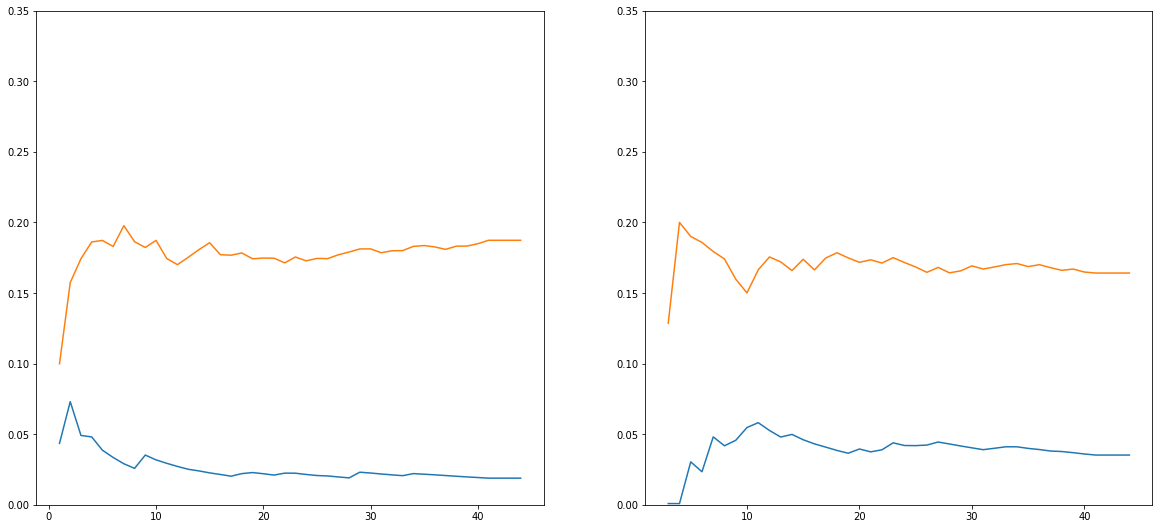

In [100]:
plt.figure(figsize=(20,20))
ax1=plt.subplot(2, 2, 1)
xrange = np.arange(45)
for repeat1, repeat2 in zip(no_weights, with_weights):
    beep = np.array([np.mean(repeat1[:i]) for i in xrange])
    boop = np.array([np.mean(repeat2[:i]) for i in xrange])
    #plt.plot(xrange, beep-boop)
    plt.plot(xrange, beep)
plt.ylim(0,0.35)

ax2 = plt.subplot(2,2,2)
for repeat1, repeat2 in zip(no_weights, with_weights):
    beep = np.array([np.mean(repeat1[2:i]) for i in xrange])
    boop = np.array([np.mean(repeat2[2:i]) for i in xrange])
    #plt.plot(xrange, beep-boop)
    plt.plot(xrange, boop)
plt.ylim(0,0.35)

/home/lewis/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lewis/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/lewis/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/lewis/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/lewis/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.0, 0.03)

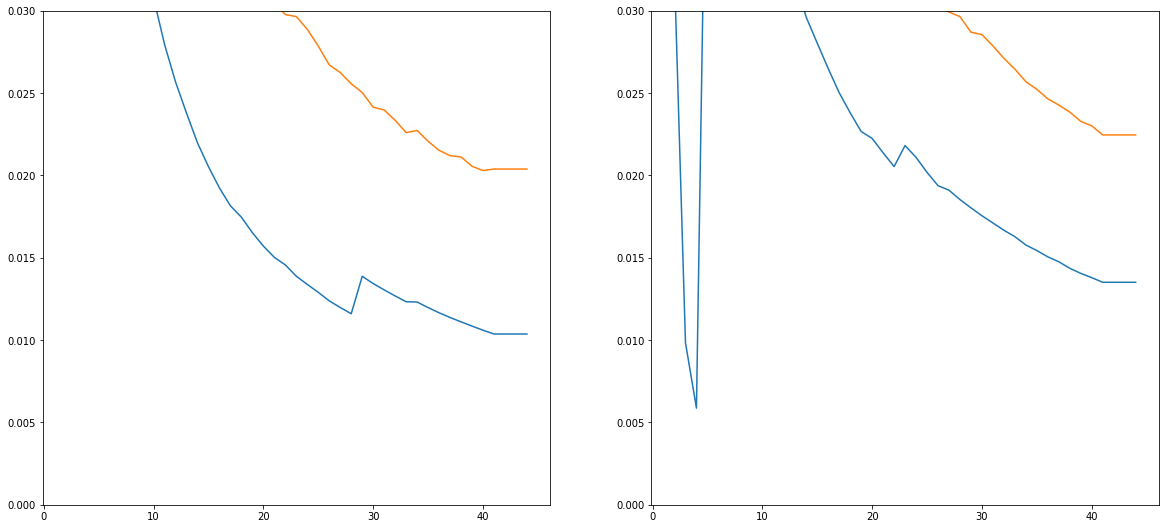

In [101]:
plt.figure(figsize=(20,20))
ax1=plt.subplot(2, 2, 1)
for repeat1, repeat2 in zip(no_weights, with_weights):
    beep = np.array([mean_confidence_interval(repeat1[:i])[1] for i in xrange])

    #plt.plot(xrange, beep-boop)
    plt.plot(xrange, beep)
plt.ylim(0.00,0.03)

ax2 = plt.subplot(2,2,2)
for repeat1, repeat2 in zip(no_weights, with_weights):
    boop = np.array([mean_confidence_interval(repeat2[:i])[1] for i in xrange])
    plt.plot(xrange, boop)
plt.ylim(0.00,0.03)

In [103]:
scipy.stats.sem(repeat1)

0.010084860680859781

In [105]:
scipy.stats.sem(repeat1[:-10])

0.011736410955462873

In [99]:
scipy.stats.sem(ranking_losses)*100

1.1109983963971133

In [61]:
#borrowed, see: https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
import scipy
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h


In [45]:
confidence_intervals2 = list()
means = list()
for ran in range(repeats):
    rl = ranking_losses2[:ran]
    mean, conf_interval = mean_confidence_interval(rl)
    means.append(mean)
    confidence_intervals2.append(conf_interval)
    
confidence_intervals3 = list()
means = list()
for ran in range(repeats):
    rl = ranking_losses3[:ran]
    mean, conf_interval = mean_confidence_interval(rl)
    means.append(mean)
    confidence_intervals3.append(conf_interval)

/Users/lmar3213/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lmar3213/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/lmar3213/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/lmar3213/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/lmar3213/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Confidence interval')

<Figure size 432x288 with 0 Axes>

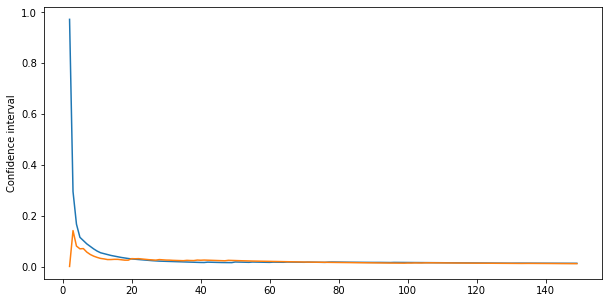

In [46]:
plt.figure()
plt.figure(figsize=(10,5))
plt.plot(confidence_intervals2)
plt.plot(confidence_intervals3)
plt.ylabel('Confidence interval')


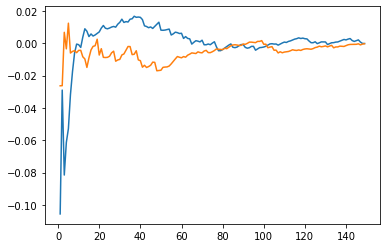

In [47]:
xrange = range(repeats)
plt.plot(xrange, [np.mean(ranking_losses2[:repeats])-np.mean(ranking_losses2[:i]) for i in xrange])
plt.plot(xrange, [np.mean(ranking_losses3[:repeats])-np.mean(ranking_losses3[:i]) for i in xrange])